# Определение стоимости автомобилей

В нашем распоряжении следующие данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from pandas.core.common import SettingWithCopyWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
data= pd.read_csv(r'C:\Users\mind2\Downloads\autos.csv', sep=',') 
data.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
208527,2016-03-13 23:52:25,2550,sedan,2004,manual,120,megane,150000,9,gasoline,renault,no,2016-03-13 00:00:00,0,48683,2016-03-17 18:16:37
42590,2016-03-25 20:55:54,2950,sedan,1995,manual,174,a4,150000,11,petrol,audi,yes,2016-03-25 00:00:00,0,50170,2016-04-07 05:16:42
348370,2016-03-27 13:46:46,3249,bus,2004,manual,101,meriva,150000,9,gasoline,opel,no,2016-03-27 00:00:00,0,42499,2016-04-07 09:45:30
196624,2016-03-08 12:45:48,6000,wagon,2003,auto,179,a4,150000,10,gasoline,audi,no,2016-03-08 00:00:00,0,25524,2016-03-15 06:45:34
280450,2016-03-09 15:38:57,6450,sedan,2002,auto,231,x_reihe,150000,4,petrol,bmw,no,2016-03-09 00:00:00,0,49143,2016-04-02 22:19:06
55180,2016-03-08 08:57:57,1900,small,2004,manual,60,2_reihe,100000,3,petrol,peugeot,no,2016-03-08 00:00:00,0,56727,2016-03-20 18:33:39
214281,2016-03-27 00:42:44,5199,small,2006,manual,75,polo,90000,5,petrol,volkswagen,no,2016-03-26 00:00:00,0,38467,2016-04-06 17:17:03
27508,2016-03-20 11:50:46,950,wagon,1999,manual,0,NaN,150000,0,NaN,volkswagen,NaN,2016-03-20 00:00:00,0,26835,2016-03-25 10:46:37
18154,2016-03-30 10:52:39,200,small,1992,manual,50,corsa,125000,2,petrol,opel,no,2016-03-30 00:00:00,0,85125,2016-03-30 10:52:39
134728,2016-03-08 19:42:21,3000,wagon,1999,auto,279,e_klasse,150000,4,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,22848,2016-04-05 13:44:30


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Датасет состоит из 16 колонок и 354369 строк. Из них 7 столбцов являются целочисленными, а остальные либо текстовые, либо отображающие время. В колонках 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired' содержатся пропущенные значения.

In [4]:
pd.options.display.max_rows = 400000

Создадим функцию для отображения количества пропущенных значений в долях, отсортированных по уменьшению:

In [5]:
def func (d):
    display(d.isna().mean().sort_values(ascending=False).to_frame())

Проведем анализ дублирующих ячеек.

In [6]:
def duplicate(data):
    content = []
    content = data.duplicated().sum()
    display('Количество дублирующих ячеек',content)

duplicate(data)

'Количество дублирующих ячеек'

4

In [7]:
data = data.drop_duplicates().reset_index(drop = True)
duplicate(data)

'Количество дублирующих ячеек'

0

In [8]:
data.columns = data.columns.str.lower()

In [9]:
data['datecrawled'].value_counts().head(10)

2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-02 22:54:55    5
2016-03-31 16:50:28    5
2016-03-19 12:50:39    5
2016-04-04 22:38:11    5
2016-04-01 19:25:23    5
2016-03-28 10:36:47    5
2016-03-09 16:48:39    5
Name: datecrawled, dtype: int64

В столбце 'datecrawled' аномалий не обнаружено. Данные имеют формат даты.

In [10]:
data['datecreated'].value_counts().head(10)

2016-04-03 00:00:00    13718
2016-04-04 00:00:00    13317
2016-03-20 00:00:00    12918
2016-03-12 00:00:00    12840
2016-03-21 00:00:00    12691
2016-03-14 00:00:00    12478
2016-03-28 00:00:00    12474
2016-04-02 00:00:00    12362
2016-03-07 00:00:00    12244
2016-03-19 00:00:00    12197
Name: datecreated, dtype: int64

В столбце 'datecreated' аномалий не обнаружено. Данные имеют формат даты.

In [11]:
data['numberofpictures'].value_counts()

0    354365
Name: numberofpictures, dtype: int64

В столбце 'numberofpictures' все данные имеют значение 0. Не могут быть все объявления без фотографий!

In [12]:
data['postalcode'].value_counts().head(10)

10115    819
65428    613
66333    343
44145    317
32257    317
52525    306
26789    296
78224    293
38518    291
13357    290
Name: postalcode, dtype: int64

В столбце 'postalcode' аномалий не выявлено. Почтовые индексы имеют числовые целочисленные значения.

In [13]:
data['lastseen'].value_counts().head(10)

2016-04-06 13:45:54    17
2016-04-06 08:46:30    16
2016-04-06 09:46:00    16
2016-04-07 13:17:48    16
2016-04-07 08:16:54    16
2016-04-07 09:44:27    16
2016-04-06 01:15:23    16
2016-04-07 00:45:17    16
2016-04-06 10:15:26    16
2016-04-06 09:17:58    16
Name: lastseen, dtype: int64

В столбце 'lastseen' аномалий не обнаружено. Данные имеют формат даты.

In [14]:
data['registrationmonth'].value_counts()

0     37352
3     34373
6     31507
4     29270
5     29153
7     27211
10    26099
12    24289
11    24186
9     23813
1     23218
8     22627
2     21267
Name: registrationmonth, dtype: int64

In [15]:
data.query('registrationmonth == 0 ').head(10)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01 00:00:00,0,47249,2016-04-07 08:46:07
80,2016-04-01 22:39:35,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes,2016-04-01 00:00:00,0,8396,2016-04-05 20:18:14
92,2016-03-16 07:56:19,250,NaN,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16 00:00:00,0,51427,2016-03-21 09:47:08
94,2016-03-28 16:37:43,8390,NaN,2009,NaN,0,insignia,150000,0,NaN,opel,NaN,2016-03-28 00:00:00,0,29221,2016-03-30 07:44:59


В столбце 'registrationmonth' присутствуют значения 0. 

In [16]:
func(data)

,0
notrepaired,0.200793
vehicletype,0.105795
fueltype,0.092828
gearbox,0.055968
model,0.055607
lastseen,0.000000
postalcode,0.000000
numberofpictures,0.000000
datecreated,0.000000
brand,0.000000


In [17]:
def val(tble):
    display(tble)
    display(data[tble].value_counts().to_frame())
    display()

val('model')

'model'

,model
golf,29232
other,24420
3er,19761
polo,13066
corsa,12570
astra,10809
passat,10145
a4,9900
c_klasse,8312
5er,7868


В столбце 'model' содержатся 5.5% пропущенных значений. В столбце существуют значения 'other'. Переведем пропущенные значения в значения 'other'.

In [18]:
data['model'] = data['model'].fillna('other')
val('model')

'model'

,model
other,44125
golf,29232
3er,19761
polo,13066
corsa,12570
astra,10809
passat,10145
a4,9900
c_klasse,8312
5er,7868


In [19]:
func(data)

,0
notrepaired,0.200793
vehicletype,0.105795
fueltype,0.092828
gearbox,0.055968
lastseen,0.000000
postalcode,0.000000
numberofpictures,0.000000
datecreated,0.000000
brand,0.000000
registrationmonth,0.000000


In [20]:
data_gear = data[data['gearbox'].isna()]
display(data_gear.sample(10))
val('gearbox')

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
121663,2016-04-05 10:54:39,1100,sedan,1984,NaN,26,other,60000,0,NaN,trabant,NaN,2016-04-05 00:00:00,0,6567,2016-04-07 14:56:38
326269,2016-03-25 22:57:51,0,NaN,2008,NaN,0,qashqai,150000,0,NaN,nissan,NaN,2016-03-25 00:00:00,0,42719,2016-03-27 18:47:53
140358,2016-03-30 20:44:20,150,NaN,2016,NaN,75,golf,150000,0,NaN,volkswagen,NaN,2016-03-30 00:00:00,0,26831,2016-03-30 20:44:20
332831,2016-03-07 20:38:54,850,NaN,2005,NaN,0,other,150000,0,gasoline,ford,NaN,2016-03-07 00:00:00,0,32052,2016-03-10 15:49:41
152202,2016-03-26 19:49:37,2300,NaN,2000,NaN,0,other,150000,0,petrol,volkswagen,NaN,2016-03-26 00:00:00,0,12099,2016-03-31 16:46:47
138055,2016-04-04 16:52:36,590,other,1994,NaN,0,other,30000,0,NaN,sonstige_autos,NaN,2016-04-04 00:00:00,0,84168,2016-04-06 18:46:36
221702,2016-03-30 20:44:47,0,NaN,2000,NaN,0,focus,5000,0,NaN,ford,NaN,2016-03-30 00:00:00,0,73453,2016-04-07 12:45:59
60308,2016-03-16 15:49:44,2600,small,2004,NaN,0,golf,150000,6,gasoline,volkswagen,NaN,2016-03-16 00:00:00,0,18106,2016-03-16 15:49:44
292278,2016-03-15 01:47:20,4450,convertible,2002,NaN,200,astra,150000,7,petrol,opel,NaN,2016-03-14 00:00:00,0,92283,2016-04-07 10:44:19
234957,2016-04-04 10:58:09,499,NaN,2017,NaN,0,corsa,150000,11,NaN,opel,no,2016-04-04 00:00:00,0,35638,2016-04-05 12:15:18


'gearbox'

,gearbox
manual,268249
auto,66283


Информация о типе коробки передач очень важная для оценки стоимости автомобиля. Исходя из вышеуказанных данных, наблюдаем, что помимо типа коробки передач в строках, как правило, отсуствует другая информация об автомобиле. Так как информация о пропущенных значениях коробки передач составляет 5.6%, то удаление не повлияет на обучение моделей.

In [21]:
data = data[data['gearbox'].notnull()]
func(data)

,0
notrepaired,0.174471
vehicletype,0.082264
fueltype,0.071667
lastseen,0.000000
postalcode,0.000000
numberofpictures,0.000000
datecreated,0.000000
brand,0.000000
registrationmonth,0.000000
kilometer,0.000000


В колонке тип топлива 'gasoline' и 'petrol', а также 'cng' и 'lpg' несут одинаковую смысловую нагрузку. Объединим вышеуказанную информацию. В столбце содержится 7,2% пропущенных значений. Заменим пропущенные значения методом 'ffill'. Данное заполнение является адекватным, так как значения типов топлива сильно разнятся и замена данным методом не повлияет на соотношение. Тип топлива не сильно влияет на стоимость автомобиля.

In [22]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
display(val('fueltype'))
data['fueltype'] = data['fueltype'].replace('gasoline','petrol')
data['fueltype'] = data['fueltype'].replace('cng','lpg')
data['fueltype'] = data['fueltype'].fillna(method='ffill')
val('fueltype')

'fueltype'

,fueltype
petrol,209252
gasoline,95125
lpg,5174
cng,551
hybrid,227
other,150
electric,78


None

'fueltype'

,fueltype
petrol,327847
lpg,6191
hybrid,245
other,163
electric,86


Для столбцов 'vehicletype'(8,2%) и 'notrepaired'(17,4%) переименум пропущенные значения в значения 'other'. Аномалий в столбцах 'vehicletype' и 'notrepaired' не выявлено.

In [23]:
data['vehicletype'] = data['vehicletype'].fillna('other')
display(val('vehicletype'))
data['notrepaired'] = data['notrepaired'].fillna('other')
val('notrepaired')

'vehicletype'

,vehicletype
sedan,89048
small,76628
wagon,63430
other,30568
bus,27973
convertible,19522
coupe,15702
suv,11661


None

'notrepaired'

,notrepaired
no,241626
other,58366
yes,34540


In [24]:
val('brand')

'brand'

,brand
volkswagen,72353
opel,37648
bmw,35451
mercedes_benz,30720
audi,28147
ford,23770
renault,16816
peugeot,10504
fiat,8987
seat,6601


Аномалий в столбце 'brand' не выявлено.

In [25]:
val('kilometer')

'kilometer'

,kilometer
150000,225356
125000,34942
100000,13973
90000,11167
80000,9667
70000,8310
60000,7180
50000,5990
40000,4751
5000,4293


Аномалий в столбце 'kilometer' не выявлено.

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334532 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        334532 non-null  object
 1   price              334532 non-null  int64 
 2   vehicletype        334532 non-null  object
 3   registrationyear   334532 non-null  int64 
 4   gearbox            334532 non-null  object
 5   power              334532 non-null  int64 
 6   model              334532 non-null  object
 7   kilometer          334532 non-null  int64 
 8   registrationmonth  334532 non-null  int64 
 9   fueltype           334532 non-null  object
 10  brand              334532 non-null  object
 11  notrepaired        334532 non-null  object
 12  datecreated        334532 non-null  object
 13  numberofpictures   334532 non-null  int64 
 14  postalcode         334532 non-null  int64 
 15  lastseen           334532 non-null  object
dtypes: int64(7), object(

In [27]:
display(val('power'))
data.query('power > 500 and power<2000')

'power'

,power
0,26916
75,23354
60,15422
150,14348
101,13034
140,12691
90,12417
116,11761
105,10223
170,10020


None

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
3746,2016-03-21 14:48:31,0,other,2017,manual,750,other,150000,8,petrol,smart,no,2016-03-21 00:00:00,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,petrol,mitsubishi,no,2016-04-03 00:00:00,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,other,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31 00:00:00,0,44379,2016-04-01 03:41:52
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,other,2016-03-14 00:00:00,0,40721,2016-03-14 15:54:34
6637,2016-03-31 19:48:22,600,small,1996,manual,603,corsa,150000,8,petrol,opel,yes,2016-03-31 00:00:00,0,70327,2016-04-06 14:17:51
7720,2016-04-02 11:48:54,1500,small,2000,manual,1400,other,150000,0,petrol,honda,other,2016-04-02 00:00:00,0,21509,2016-04-04 09:15:26
8057,2016-03-15 13:49:25,500,small,2002,manual,620,ypsilon,150000,12,petrol,lancia,other,2016-03-15 00:00:00,0,55566,2016-04-06 03:15:27
9664,2016-03-14 20:06:19,2599,other,2016,manual,1779,zafira,150000,0,petrol,opel,no,2016-03-14 00:00:00,0,60326,2016-04-07 09:45:27


Удалим значения в столбце 'power'(27 380), которые больше 500 и равны 0 л.с. Во избежание удаления редких и дорогих автомобилей оставим автомобили с мощностью до 500 л.с.

In [28]:
data = data.query('power < 500 and power !=0')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307152 entries, 1 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        307152 non-null  object
 1   price              307152 non-null  int64 
 2   vehicletype        307152 non-null  object
 3   registrationyear   307152 non-null  int64 
 4   gearbox            307152 non-null  object
 5   power              307152 non-null  int64 
 6   model              307152 non-null  object
 7   kilometer          307152 non-null  int64 
 8   registrationmonth  307152 non-null  int64 
 9   fueltype           307152 non-null  object
 10  brand              307152 non-null  object
 11  notrepaired        307152 non-null  object
 12  datecreated        307152 non-null  object
 13  numberofpictures   307152 non-null  int64 
 14  postalcode         307152 non-null  int64 
 15  lastseen           307152 non-null  object
dtypes: int64(7), object(

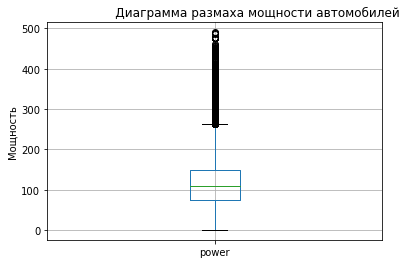

In [30]:
data.boxplot(column='power')
plt.title('                      Диаграмма размаха мощности автомобилей')
plt.ylabel('Мощность')
plt.show()

In [31]:
val('registrationyear')

'registrationyear'

,registrationyear
1999,19758
2005,18796
2000,18731
2006,18493
2001,17915
2003,17872
2004,17775
2002,17183
2007,16006
1998,15422


Удалим значения с годом регистрации больше 2019 (15 значений).

In [32]:
data = data.query('registrationyear < 2020')

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307137 entries, 1 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        307137 non-null  object
 1   price              307137 non-null  int64 
 2   vehicletype        307137 non-null  object
 3   registrationyear   307137 non-null  int64 
 4   gearbox            307137 non-null  object
 5   power              307137 non-null  int64 
 6   model              307137 non-null  object
 7   kilometer          307137 non-null  int64 
 8   registrationmonth  307137 non-null  int64 
 9   fueltype           307137 non-null  object
 10  brand              307137 non-null  object
 11  notrepaired        307137 non-null  object
 12  datecreated        307137 non-null  object
 13  numberofpictures   307137 non-null  int64 
 14  postalcode         307137 non-null  int64 
 15  lastseen           307137 non-null  object
dtypes: int64(7), object(

In [34]:
val('price')

'price'

,price
0,6459
1500,4523
500,4472
1200,3811
2500,3754
1000,3688
3500,3355
800,3070
600,3042
2000,2874


Удалим 6459 строк, цена которых равна 0.

In [35]:
data = data.query('price != 0')

Информация: дата скачивания анкеты из базы, дата создания анкеты, количество фотографий в анкете, почтовый индекс владельца анкеты, дата последней активности пользователя, месяц регистрации автомобиля не зависит от целевого признака (цена автомобиля). Удаляем данные из датасета. 

In [36]:
data = data.drop(['datecrawled','datecreated', 'numberofpictures', 'postalcode', 'lastseen', 'registrationmonth'], axis=1)

In [37]:
display(data.sample())

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
303206,549,sedan,1994,manual,75,golf,150000,petrol,volkswagen,no


Для уменьшения объема информации изменим формат целочисленных значений.

In [38]:
def n_type(st,ty):
    data[st] = data[st].astype(ty)

In [39]:
n_type('price','uint32')
n_type('registrationyear','uint16')
n_type('power','uint16')
n_type('kilometer','uint32')

Проведем проверку дублирующих строк:

In [40]:
def duplicate(data):
    content = []
    content = data.duplicated().sum()
    print('Количество дублирующих ячеек',content)

duplicate(data)

Количество дублирующих ячеек 42217


Проведем удаление дублирующих ячеек

In [41]:
data = data.drop_duplicates().reset_index(drop = True)
duplicate(data)

Количество дублирующих ячеек 0


После проведения предварительной подготовки информации получаем датасет со следующими характеристиками:

In [42]:
display(data.sample(5))
data.info()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
169291,7999,small,2012,manual,90,polo,125000,petrol,volkswagen,no
115160,3300,sedan,2002,auto,116,3er,150000,petrol,bmw,no
139272,700,small,2001,manual,58,corsa,150000,petrol,opel,yes
24764,9950,suv,2006,auto,174,touareg,150000,petrol,volkswagen,no
44904,1150,bus,1998,manual,114,espace,150000,petrol,renault,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258461 entries, 0 to 258460
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             258461 non-null  uint32
 1   vehicletype       258461 non-null  object
 2   registrationyear  258461 non-null  uint16
 3   gearbox           258461 non-null  object
 4   power             258461 non-null  uint16
 5   model             258461 non-null  object
 6   kilometer         258461 non-null  uint32
 7   fueltype          258461 non-null  object
 8   brand             258461 non-null  object
 9   notrepaired       258461 non-null  object
dtypes: object(6), uint16(2), uint32(2)
memory usage: 14.8+ MB


Проведем подготовку данных для избежания ловушки фиктивных признаков:

In [43]:
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe.dtypes)
data_ohe.shape

price                       uint32
registrationyear            uint16
power                       uint16
kilometer                   uint32
vehicletype_convertible      uint8
vehicletype_coupe            uint8
vehicletype_other            uint8
vehicletype_sedan            uint8
vehicletype_small            uint8
vehicletype_suv              uint8
vehicletype_wagon            uint8
gearbox_manual               uint8
model_145                    uint8
model_147                    uint8
model_156                    uint8
model_159                    uint8
model_1_reihe                uint8
model_1er                    uint8
model_200                    uint8
model_2_reihe                uint8
model_300c                   uint8
model_3_reihe                uint8
model_3er                    uint8
model_4_reihe                uint8
model_500                    uint8
model_5_reihe                uint8
model_5er                    uint8
model_601                    uint8
model_6_reihe       

(258461, 305)

Проведем разделение признаков:

In [44]:
features = data_ohe.drop(['price'], axis=1)
target = data_ohe['price']

Разобьем датасеты "features" и "target" на тренировочную выборку (60 % объектов), проверочную выборку (15% объектов) и тестовую выборку (15% объектов).

In [45]:
features_train, features_tes, target_train, target_tes = train_test_split(
    features, target, test_size=0.4, train_size=0.6, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_tes, target_tes, test_size=0.5, train_size=0.5, random_state=12345)

Проверка правильности разделения датасета:

In [46]:
display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
display(target_test.shape)

(155076, 304)

(155076,)

(51692, 304)

(51692,)

(51693, 304)

(51693,)

Датасет представляет из себя набор числовых данных с разным форматом. Проведем масштабирование данных:

In [47]:
numeric = ['registrationyear', 'power', 'kilometer']
pd.options.mode.chained_assignment = None

In [48]:
scaler = StandardScaler()

scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Получили данные, подготовленные для проведения обучения и выполнения задания.

In [49]:
features_train.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_other,notrepaired_yes
37283,0.642779,0.911744,0.609148,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
167358,0.781859,-0.306031,-1.260737,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
191911,-1.721574,-1.261517,0.609148,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
117025,-1.026176,-0.868082,0.609148,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
98204,0.920938,-0.830612,-0.726484,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### Вывод:

1. Датасет состоит из 16 колонок и 354369 строк. Из них 7 столбцов являются целочисленными, а остальные либо текстовые, либо отображающие время. В колонках 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired' содержатся пропущенные значения.
2. Провели удаление следующих столбцов: 'DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth', не влияющих на расчет стоимости автомобилей.
3. В столбце 'model' содержатся 5.5% пропущенных значений. Переведем пропущенные значения в значения 'other'.
4. Информация о пропущенных значениях коробок передач составляет 5.6%. Провели удаление данных.
5. В колонке тип топлива 'gasoline' и 'petrol', а также 'cng' и 'lpg' несут одинаковую смысловую нагрузку. Объединим вышеуказанную информацию. В столбце содержится 7,2% пропущенных значений. Заменим пропущенные значения методом 'ffill'. 
6. Для столбцов 'vehicletype'(8,2%) и 'notrepaired'(17,4%) переименум пропущенные значения в значения 'other'.
7. Для уменьшения объема информации изменили формат целочисленных значений. Объем уменьшился с 43.3 mb до 14.8 mb.
8. Провели удаление 42217 дублирующих ячеек.
9. Провели подготовку данных для избежания ловушки фиктивных признаков.
10. Провели разделение признаков. Разбили датасеты "features" и "target" на тренировочную выборку (60 % объектов), проверочную выборку (15% объектов) и тестовую выборку (15% объектов). Провели масштабирование данных.
11. Удалил 27 380 значений в столбце 'power', которые больше 500 и равны 0 л.с. для стандартных автомобилей.
12. Удалил 15 значений в столбце 'registrationyear' с годом регистрации больше 2019.
13. Удалил 6459 строк в столбце 'price', цена которых равна 0.
14. В столбце 'numberofpictures'содержатся только со значением 0.
15. В столбце'registrationmonth' есть значение 0.

## Обучение моделей

Проведем обучение модели **градиентного бустинга LGBMRegressor на параметрах default**. 

In [50]:
%%time
model = LGBMRegressor()
model.fit(features_train, target_train)

Wall time: 34.4 s


LGBMRegressor()

In [51]:
predictions = model.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions) ** 0.5
display(rmse)

1736.9307032967379

Проведем обучение модели **градиентного бустинга LGBMRegressor с подбором параметров max_depth и n_estimators**. 

In [52]:
%%time
best_model_1 = None
best_rmse = 3000
for depth in range(6,9):
    for estimators in range(1,150):
        model_1 = LGBMRegressor(max_depth=depth, n_estimators=estimators, random_state=12345)
        model_1.fit(features_train, target_train)
        predictions = model_1.predict(features_valid)
        display(depth, estimators)
        rmse = mean_squared_error(target_valid, predictions)**0.5
        display(rmse)
        if rmse < best_rmse:
            best_model_1 = model_1
            best_rmse = rmse
display(best_model_1,best_rmse)

6

1

4321.599055737641

6

2

4030.8804498202535

6

3

3778.0110165363203

6

4

3553.9005541429547

6

5

3356.5321733912633

6

6

3184.129593565435

6

7

3034.6622197190313

6

8

2896.7276228966334

6

9

2775.0271192957466

6

10

2676.3274611361817

6

11

2584.2300061299443

6

12

2508.615195624385

6

13

2440.7775019940495

6

14

2379.4693009846574

6

15

2329.1805624332123

6

16

2281.268423880881

6

17

2238.8077061907597

6

18

2200.0682592852404

6

19

2165.2589412446528

6

20

2133.404837633432

6

21

2107.635851909159

6

22

2083.341585764374

6

23

2060.736275947964

6

24

2041.1752408633295

6

25

2022.5558740522122

6

26

2006.6957659343832

6

27

1991.674057539824

6

28

1975.9273805366524

6

29

1963.2474728582606

6

30

1952.1358528677933

6

31

1939.842464964688

6

32

1931.4725167106544

6

33

1921.3888905214994

6

34

1911.7711395193887

6

35

1905.2167405355337

6

36

1896.2953449069273

6

37

1890.577396829366

6

38

1883.6804471311725

6

39

1878.5185802503263

6

40

1873.1064105080527

6

41

1866.8005163959492

6

42

1862.774852141154

6

43

1858.6098377426063

6

44

1855.1895194402684

6

45

1851.5724409404972

6

46

1846.85884942659

6

47

1843.2664784653684

6

48

1841.2936395942834

6

49

1838.5254676576462

6

50

1836.3359100898053

6

51

1833.700376819338

6

52

1831.4289213862016

6

53

1829.9279551577479

6

54

1826.6648573228247

6

55

1823.3398187143896

6

56

1821.9338986451974

6

57

1820.743942515332

6

58

1819.250501784251

6

59

1817.4985127068178

6

60

1816.0012086347115

6

61

1814.738909618875

6

62

1812.8442554105989

6

63

1811.8763770824314

6

64

1810.908118487123

6

65

1808.6952863178187

6

66

1807.9637790385964

6

67

1806.0109916158412

6

68

1805.048112730189

6

69

1803.7812417656303

6

70

1802.516150149163

6

71

1801.8920373336682

6

72

1800.434524676236

6

73

1799.5017086995756

6

74

1798.4674538654383

6

75

1797.3450278784699

6

76

1796.4324440317866

6

77

1795.3482172452152

6

78

1794.6966274102344

6

79

1794.2432949736258

6

80

1793.0861355653194

6

81

1792.5358151090386

6

82

1791.2220443113197

6

83

1790.0679052688574

6

84

1789.217331920618

6

85

1788.7203644736549

6

86

1788.2321954390522

6

87

1787.7622011788937

6

88

1787.2303298931627

6

89

1786.8727014199267

6

90

1786.3405437255942

6

91

1785.7549070204157

6

92

1785.3873875151078

6

93

1784.096907188204

6

94

1782.571810576507

6

95

1782.0331046489246

6

96

1780.508180700055

6

97

1777.9798293618176

6

98

1777.628143331228

6

99

1777.0670292449859

6

100

1776.840171522501

6

101

1776.0829228529967

6

102

1775.4178370518785

6

103

1774.6526172231777

6

104

1774.3140270304164

6

105

1773.9483181292362

6

106

1773.4080269036106

6

107

1773.106028022786

6

108

1771.0520198355225

6

109

1770.6040253247365

6

110

1769.8447532007342

6

111

1769.224555404863

6

112

1768.8369109411306

6

113

1768.4650026672027

6

114

1768.0987004929998

6

115

1767.6955379635783

6

116

1766.9470442886104

6

117

1766.5834666438438

6

118

1766.4043814497545

6

119

1765.698730376404

6

120

1764.7851716515856

6

121

1764.3406729861163

6

122

1763.9945724575712

6

123

1763.4571321023109

6

124

1763.1393899395644

6

125

1762.36518453302

6

126

1762.110018190577

6

127

1761.7753752854978

6

128

1761.3546989201432

6

129

1760.790814253659

6

130

1760.379984518966

6

131

1760.2925758207796

6

132

1759.4000020368126

6

133

1759.1661566922535

6

134

1757.3713687554011

6

135

1756.9004745873053

6

136

1756.682873946657

6

137

1755.7791191243714

6

138

1755.187936699643

6

139

1755.0483971004326

6

140

1754.8533381218717

6

141

1754.3666756742612

6

142

1754.1032888963719

6

143

1752.9518250854258

6

144

1752.706475153365

6

145

1752.3472331737262

6

146

1751.937257413357

6

147

1751.4282786319634

6

148

1750.9170415683916

6

149

1749.8818843270428

7

1

4320.88362218216

7

2

4030.70101416534

7

3

3774.134522008008

7

4

3551.191917839708

7

5

3353.8142443683378

7

6

3180.9889636282155

7

7

3031.5928293063735

7

8

2892.8439819084238

7

9

2772.80092343691

7

10

2668.2746881010294

7

11

2581.1183857530773

7

12

2502.692497125826

7

13

2435.0904143545627

7

14

2376.5109007841406

7

15

2322.0196584334217

7

16

2274.6186409872203

7

17

2233.6827351236648

7

18

2195.1478284312107

7

19

2161.5953745692364

7

20

2127.9184941397248

7

21

2098.2208772596164

7

22

2073.9621080960283

7

23

2051.2293642204877

7

24

2030.4375438164893

7

25

2011.6234123524348

7

26

1996.4182633370913

7

27

1979.3721601255809

7

28

1964.942422815633

7

29

1952.332709863336

7

30

1939.3205091766754

7

31

1928.3939600714655

7

32

1918.4043324024651

7

33

1908.1505952005805

7

34

1900.100178063438

7

35

1892.8020160336887

7

36

1886.915713573032

7

37

1881.1477920733983

7

38

1875.7559582526726

7

39

1867.748321955677

7

40

1863.0642374567417

7

41

1858.681786811735

7

42

1853.23826991203

7

43

1848.0582174344213

7

44

1844.5384784544028

7

45

1841.0036932580388

7

46

1838.1088530211714

7

47

1835.0576932589233

7

48

1831.9280018577479

7

49

1828.1832908578044

7

50

1825.5854433136342

7

51

1822.742692209849

7

52

1821.1223998951077

7

53

1819.1718200114265

7

54

1816.7441145102914

7

55

1814.2466095918187

7

56

1812.5343826054686

7

57

1811.134794457909

7

58

1808.469035306327

7

59

1807.523266049162

7

60

1806.4799997792802

7

61

1804.3920083355301

7

62

1801.7915224108062

7

63

1800.9070939999929

7

64

1799.5950065003494

7

65

1798.6628900054384

7

66

1797.7448804613073

7

67

1797.1985166317274

7

68

1795.932435390749

7

69

1794.708856976547

7

70

1793.7351681778487

7

71

1793.1791596161922

7

72

1792.2381823658998

7

73

1791.4383630465272

7

74

1790.919329683295

7

75

1788.5644595743588

7

76

1787.2909065248425

7

77

1786.0128435811137

7

78

1785.332834845782

7

79

1784.8034610903658

7

80

1784.3619449818752

7

81

1783.778339231368

7

82

1783.1111406768814

7

83

1781.060469521461

7

84

1780.4230111456993

7

85

1778.1343076652745

7

86

1777.1527935279673

7

87

1775.9160446633252

7

88

1775.5284520199523

7

89

1775.0290601276654

7

90

1774.4841025627543

7

91

1773.7794063211832

7

92

1773.1650313359842

7

93

1772.7922514157224

7

94

1771.968152256251

7

95

1770.9434106538033

7

96

1769.5674901984219

7

97

1768.9108714175438

7

98

1768.0756576042834

7

99

1767.5122404641086

7

100

1765.569437131569

7

101

1765.2296796342425

7

102

1764.613391579544

7

103

1763.67410500536

7

104

1762.8098316089445

7

105

1762.263452487777

7

106

1761.8029630649523

7

107

1761.43278439576

7

108

1761.1345817160784

7

109

1759.8569533955151

7

110

1759.5927265670837

7

111

1759.4214723861094

7

112

1759.0645063052757

7

113

1758.5431826471295

7

114

1758.1889794812014

7

115

1757.625036034165

7

116

1757.1768709357252

7

117

1755.4137742318221

7

118

1753.8771572807934

7

119

1753.4507717803328

7

120

1752.8606213698502

7

121

1752.482741440753

7

122

1752.0527876450906

7

123

1751.9076745285258

7

124

1751.6083279237355

7

125

1751.3130606914865

7

126

1750.652093886675

7

127

1749.2558116303883

7

128

1748.0441035859515

7

129

1747.4069178374325

7

130

1747.1900683475424

7

131

1746.8197213724382

7

132

1746.616748034912

7

133

1746.410640720276

7

134

1746.0774400044102

7

135

1745.370251495973

7

136

1745.230043728868

7

137

1744.9311288499152

7

138

1744.6610185980983

7

139

1744.035518281722

7

140

1743.8321805872743

7

141

1742.8949026732653

7

142

1742.5961434368044

7

143

1742.259855520126

7

144

1741.9622339316445

7

145

1741.5336249573602

7

146

1740.1184548154868

7

147

1739.3332219176757

7

148

1738.942173606741

7

149

1738.3496381228051

8

1

4320.88362218216

8

2

4030.70101416534

8

3

3774.134522008008

8

4

3551.191917839708

8

5

3353.8142443683378

8

6

3180.9889636282155

8

7

3031.060011194749

8

8

2892.3958185813913

8

9

2772.79112292843

8

10

2668.8815717798034

8

11

2581.859405478407

8

12

2500.3117293481537

8

13

2431.8980332604697

8

14

2372.120771290639

8

15

2317.198368624521

8

16

2270.6557953330985

8

17

2224.9279553758424

8

18

2188.5344809886974

8

19

2151.854124264676

8

20

2121.2276748399527

8

21

2092.6059335275622

8

22

2067.0342085556726

8

23

2043.839080220833

8

24

2021.9842226853382

8

25

2005.0353593811055

8

26

1989.9424583081764

8

27

1974.0091112017192

8

28

1959.9839515541378

8

29

1945.1738565782139

8

30

1932.4126243720318

8

31

1922.711747159964

8

32

1912.9812440540873

8

33

1902.7330504336219

8

34

1893.9681279627305

8

35

1886.8211487080682

8

36

1880.0848137300472

8

37

1873.2826613959076

8

38

1867.4038518159373

8

39

1862.115242833283

8

40

1854.945851658969

8

41

1849.813050846408

8

42

1845.955098808695

8

43

1841.6225891340105

8

44

1835.787820167827

8

45

1831.9082908131666

8

46

1828.6307258396969

8

47

1826.0432857202616

8

48

1822.6504220987306

8

49

1819.3472900574889

8

50

1816.433209869229

8

51

1812.7397381477492

8

52

1810.173365467717

8

53

1807.5627899638541

8

54

1804.9744390111323

8

55

1802.3792933145025

8

56

1800.7837671479895

8

57

1798.1373563971867

8

58

1795.598087323271

8

59

1794.5419044755042

8

60

1792.3085329031974

8

61

1790.7848513602057

8

62

1789.13475342929

8

63

1786.2816666041258

8

64

1785.8327971178658

8

65

1784.0903876183636

8

66

1783.181418189787

8

67

1782.293765237479

8

68

1780.7718984040387

8

69

1779.4312192422644

8

70

1777.82318596245

8

71

1776.2398213198826

8

72

1775.5691462547954

8

73

1774.3814077015966

8

74

1772.342092942045

8

75

1771.8746025543758

8

76

1771.0034231449392

8

77

1770.2799360240408

8

78

1769.8092602115241

8

79

1768.6694612601477

8

80

1767.7125502236336

8

81

1766.5155945441095

8

82

1765.8800289588266

8

83

1765.3883993193213

8

84

1764.2260943949632

8

85

1762.773164993804

8

86

1762.4752957410403

8

87

1761.8663816704789

8

88

1761.2690349151792

8

89

1760.4186818698452

8

90

1758.1629059197744

8

91

1757.7525689112638

8

92

1757.3650846496316

8

93

1756.4830035791697

8

94

1755.561317901402

8

95

1755.0506451851854

8

96

1753.7287693464152

8

97

1753.1545659721849

8

98

1752.6243937308716

8

99

1752.333216471371

8

100

1751.7465750314557

8

101

1751.0769018671187

8

102

1750.0839724411926

8

103

1749.1254386627263

8

104

1748.5829166429014

8

105

1747.9299278543897

8

106

1746.9877794086067

8

107

1746.535234225969

8

108

1746.2400837182788

8

109

1745.5092713531421

8

110

1744.1921446510437

8

111

1743.15875120782

8

112

1742.6050992822873

8

113

1741.4649603814423

8

114

1740.7416637593806

8

115

1740.4738035400133

8

116

1740.038518510569

8

117

1739.3784107370798

8

118

1738.6432067942123

8

119

1737.623372130276

8

120

1737.1023419314954

8

121

1736.7717089843927

8

122

1736.4517829928345

8

123

1736.0148213535665

8

124

1734.6670945981016

8

125

1733.603966278351

8

126

1733.4066237994714

8

127

1732.661416900181

8

128

1731.7317960502614

8

129

1730.982773189012

8

130

1730.3951668834834

8

131

1729.8046069676157

8

132

1729.3663508486113

8

133

1729.0211301346797

8

134

1727.4390053293828

8

135

1727.1690720327906

8

136

1726.7962773801903

8

137

1726.55811006777

8

138

1726.0276860054669

8

139

1725.8159642141547

8

140

1725.1122281931846

8

141

1724.6748281916623

8

142

1723.4932747508012

8

143

1723.2564790326592

8

144

1722.9188528270736

8

145

1722.4856634051293

8

146

1722.1494712443646

8

147

1721.8693483530778

8

148

1721.5844568539687

8

149

1721.3640071827786

LGBMRegressor(max_depth=8, n_estimators=149, random_state=12345)

1721.3640071827786

Wall time: 20min 12s
Parser   : 114 ms


Проведем обучение модели **линейной регрессии**. 

In [53]:
%%time
model_2 = LinearRegression()
model_2.fit(features_train, target_train)
predictions = model_2.predict(features_valid)
rmse = mean_squared_error(target_valid, predictions)**0.5
display(rmse)

2726.9456899470415

Wall time: 8.54 s


Проведем обучение модели **решающего дерева с подбором параметра max_depth**.

In [54]:
%%time
best_model_3 = None
best_rmse = 4000
for depth in range(1, 20, 1):
    model_3 = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model_3.fit(features_train, target_train)
    predictions = model_3.predict(features_valid)
    display(depth)
    rmse = mean_squared_error(target_valid, predictions)**0.5
    display(rmse)
    if rmse < best_rmse:
        best_model_3 = model_3
        best_rmse = rmse
display(best_model_3,best_rmse)

1

3811.8433185639483

2

3327.5606930545446

3

3043.0427675164883

4

2735.493087173253

5

2514.837906136868

6

2348.911459670156

7

2233.301101398854

8

2142.5099382478647

9

2086.588041726098

10

2037.1005158125226

11

2000.3280276004698

12

1971.4860687769633

13

1951.062140854739

14

1939.2164573194873

15

1943.3045405319563

16

1949.9444328422376

17

1950.6095863646378

18

1952.6197024916023

19

1956.8405698579472

DecisionTreeRegressor(max_depth=14, random_state=12345)

1939.2164573194873

Wall time: 1min 23s


### Вывод:

Провели обучение моделей **градиентного бустинга LGBMRegressor на параметрах default**, **градиентного бустинга LGBMRegressor с подбором параметров max_depth и n_estimators**, **линейной регрессии**, **решающего дерева с подбором параметра max_depth**. 

## Анализ моделей

Сделаем расчет параметра RMSE на наилучших параметрах выбранных моделей с фиксацией времени расчета модели.

Модель **градиентного бустинга LGBMRegressor на параметрах default**

In [55]:
%%time
total_list = []
model = LGBMRegressor()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
display(rmse)
total_list.append({'Model':model, 'RMSE': rmse})

1747.926612233259

Wall time: 3.61 s


Модель **градиентного бустинга LGBMRegressor с наилучшими параметрами max_depth и n_estimators**

In [56]:
%%time
model_1 = LGBMRegressor(max_depth=8, n_estimators=149, random_state=12345)
model_1.fit(features_train, target_train)
predictions = model_1.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
display(rmse)
total_list.append({'Model':model_1, 'RMSE': rmse})

1734.237170511218

Wall time: 3.65 s


Модель **линейной регрессии**.

In [57]:
%%time
model_2 = LinearRegression()
model_2.fit(features_train, target_train)
predictions = model_2.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
display(rmse)
total_list.append({'Model':model_2, 'RMSE': rmse})

2717.19618371397

Wall time: 4.61 s


Модель **решающего дерева с наилучшим параметром max_depth**.

In [58]:
%%time
model_3 = DecisionTreeRegressor(max_depth=16, random_state=12345)
model_3.fit(features_train, target_train)
predictions = model_3.predict(features_test)
rmse = mean_squared_error(target_test, predictions)**0.5
display(rmse)
total_list.append({'Model':model_3, 'RMSE': rmse})

1963.3799020986733

Wall time: 6.41 s


Создадим таблицу с результатами для анализа

In [59]:
result_time = pd.DataFrame({'time': [3.27, 4.08, 5.62, 7.19]})

In [60]:
result=pd.DataFrame(total_list)
result['time'] = result_time['time']
result = result.sort_values(by='RMSE')
result

,Model,RMSE,time
1,"LGBMRegressor(max_depth=8, n_estimators=149, r...",1734.237171,4.08
0,LGBMRegressor(),1747.926612,3.27
3,"DecisionTreeRegressor(max_depth=16, random_sta...",1963.379902,7.19
2,LinearRegression(),2717.196184,5.62


In [61]:
result['share_rmse'] = result['RMSE'] / result.iloc[2,1]
result['share_time'] = result['time'] / result.iloc[2,2]
result

,Model,RMSE,time,share_rmse,share_time
1,"LGBMRegressor(max_depth=8, n_estimators=149, r...",1734.237171,4.08,0.883292,0.567455
0,LGBMRegressor(),1747.926612,3.27,0.890264,0.454798
3,"DecisionTreeRegressor(max_depth=16, random_sta...",1963.379902,7.19,1.000000,1.000000
2,LinearRegression(),2717.196184,5.62,1.383938,0.781641


### Вывод:

Из анализа выбранных моделей выявлено:
1. Наилучшим параметром RMSE обладает модель LGBMRegressor с параметрами max_depth = 8 и n_estimators = 149.
2. Наилучшим временем по обучению является модель DecisionTreeRegressor с параметром max_depth = 16.
3. В результате сравнения моделей получается, что улучшение параметра RMSE на 10 % приводит к увеличению времени в 2-2,5 раза. **Оптимальным соотношением для расчетов является модель DecisionTreeRegressor**.